<a href="https://colab.research.google.com/github/ptcar2009/data/blob/master/HWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten text recognition - Final Assignment 
### Pedro Tavares de Carvalho


## Abstract
This notebook implements a Neural Network to recognize handwritten text. The network is composed of a Convolutional set, a LSTM step and a CTC loss step, which was based of several other similar papers, which will be referenced in the end of the Notebook.


This notebook can also be found on my github page, by following [this link](https://github.com/ptcar2009/trabalho_ml). You can run it in Google Collaboratory by crating a new notebook and importing it from the github page mentioned above.


## Module installation
It uses the `pytorch` module for the building of the network, and the `cv2` for image input and processing. 

The packages used for the model are as stated below.

In [0]:
from PIL import Image
from matplotlib import cm
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import os
from torch.utils.data import Dataset
import cv2

## Data
The training data for this network is the IAM Handwriting Dataset, a compilation of several documents by many writers which is available for download at [this website](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database). The whole file structure is like this:

    -> Author
        -> Form
            -> Line
                -> Word
                
The `PyDrive` API was used to load the data from a Google Drive repository, if you are running the notebook from Colab.

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 3.3MB/s 


In [0]:
id = "https://drive.google.com/open?id=1PHw-SRuU0B3XBJQ1jEciTz4EqyPNy9rb".split('=')[1]
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('words.tar.gz')
id = "https://drive.google.com/open?id=1_7z4T6DiivlNMsQwYmOoz_AaZrseAKmw".split('=')[1]
downloaded = drive.CreateFile({'id':id}) 
!mkdir data
!mkdir data/words
!mkdir data/ascii
!mkdir data/saved_data
downloaded.GetContentFile('data/ascii/words.txt')
!tar xzf words.tar.gz -C data/words

The images in the dataset have various formats, variyng in width and height. The maximum for both is `(128, 32)`, respectively. As a refularization for the input on the network, the images were ligned right and scaled, with no distortion, to fit on a `(128,32)` canvas. Whenever there is leftover space, it's filled with white padding to have a consistent size.

In [0]:
input_size = (128, 32)

In [0]:
def formatImage(image, augm=False):
    x_size, y_size =  input_size# the desired size
    y_cur_size, x_cur_size = image.shape # the current shape of the image
                                         # x and y are inverted in the input
    
    max_ratio = max(x_cur_size / x_size, y_cur_size / y_size) # figuring out the maximum ratio
                                                              # between original size and desired size
                                                              # from both axes
    x_cur_size, y_cur_size = (
        min(x_size, int(x_cur_size / max_ratio)), 
        min(y_size, int(y_cur_size / max_ratio)))
        # the new size is gonna be the maximum size within both constraints, of width and height
    image = Image.fromarray(image, mode='L')
    image = transforms.Resize((y_cur_size,x_cur_size))(image)
    image = transforms.Pad((int((x_size-x_cur_size)/2),int((y_size - y_cur_size)/2),int((x_size-x_cur_size)/2), int((y_size - y_cur_size)/2)), 0)(image)
    return image

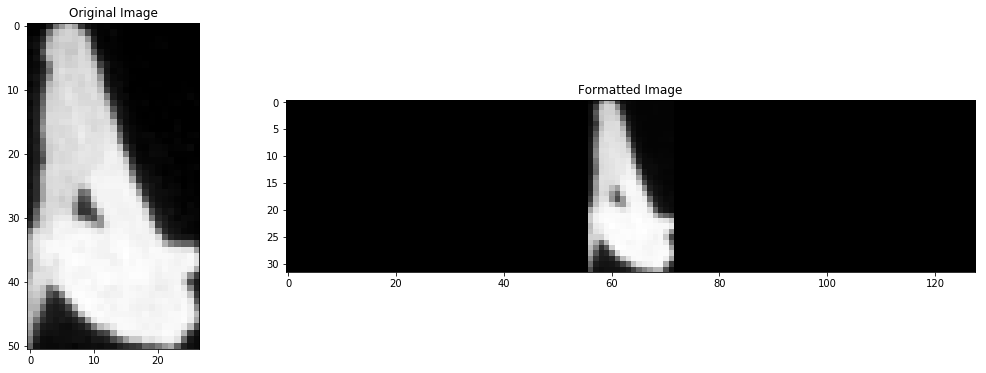

In [9]:
image = 255-cv2.imread(os.getcwd() + "/data/words/a01/a01-000u/a01-000u-00-00.png", cv2.IMREAD_GRAYSCALE)
f, (axe1, axe2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 4]}, figsize= (17,10))
axe1.set_title('Original Image')
axe1.imshow(image, cmap='gray')
img = formatImage(image)
axe2.set_title('Formatted Image')
axe2.imshow(img, cmap='gray')


The file structure, as stated earlier, is consistent throughout the whole dataset, easiyng the load up.

In [0]:
image_path = os.getcwd() +'/data/words/'
ground_truth_path = os.getcwd() + '/data/ascii/words.txt'

The image processing is done during the loading stage, freeing the training time so more experiments can be done. 

In [0]:
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
def LoadData(set, augm=True):
    "Function to load data from the IAM dataset"
    data = []
    n_img = 0
    with open(ground_truth_path) as gt_file: # for each line in the ground truth file,
                                             # whitch contains the trascripts for the words
        for cur_img, line in enumerate(gt_file): # enumarate them
            if not cur_img in set:
                continue
            n_img += 1
            if n_img % 500 == 0: #log every 500
                print('Imagem {} de {} - {}%'.format(n_img, len(set), n_img/len(set)))
                
            if line[0] != '#': # strip out comments
                parts = line.strip().split() # separate the lines in the specified format
                
                split_info = parts[0].split('-') # separate the word classification
                                                 # in pre determined segments
                    
                full_image_path = image_path + '/' + split_info[0] + '/' + '/'.join(
                    ['-'.join(split_info[: 1 + i]) for i in range(1, len(split_info)) if i != 2])
                                        # constructing the full image path, whitch is 
                                        # image_path/form/line/word.png
                        
                if parts[1] != 'ok': # if the word is invalid
                    continue
                    
                transcript = parts[-1] # the last part of the input is the transcript
                
                try:
                    image = 255.0 - cv2.imread(full_image_path + '.png', 0) # read image
                    mean = 0
                    std = 0
                    image = np.array(formatImage(image))/255
                    compose = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.float()),
                    ])
                    image = compose(image)

                except Exception as exception:
                    print(exception) # print errors that occur
                    continue
                #if augm:
                    
                data += [(transcript, image)] # Adding image to data
                
                    
    return data

To ease iteration and storage, aswell as being able to load other trained networks, the data was encapsulated in a dataset, which loads data from a `pytorch` saved file.

In [0]:
saved_data_path = os.getcwd() + '/data/saved_data/'

In [0]:
class Loader(Dataset):
    def __init__(self, set):
        self.img_size = (128, 32)
        saved_file = saved_data_path + 'model' +str(len(set)) + '.pt'
        if (os.path.isfile(saved_file)):
            self.data = torch.load(saved_file)
        else:
            self.data = LoadData(set)
            torch.save(self.data, saved_file)

    def __getitem__(self, i):
        return self.data[i]

    def __len__(self):
        return len(self.data)

## Model
For the model, the usual configuration is a convolutional step, followed by a LSTM step, and a linear transformation step to fit the output into the correct classes.




### Convolutional step
The first layers of the model configure a feature extracting convolutional network. The design has 17 convolutional layers, each with a following ReLU non-linearizing stage and a batch normalization.  

The number of kernels in the model was scaled up, as we progressed through the layers, to compensate for the loss of information in the max pooling steps.

The idea behind the convolutional step is to give some kind of 'temporal' information, moving a window through the image and formatting this image according to the steps.

In [0]:
conv = nn.Sequential(
      nn.Conv2d(1, 32, 3, padding=1, bias=True),
      nn.BatchNorm2d(32, momentum=.5),
      nn.ReLU(),
      nn.Conv2d(32, 32, 3, padding=1, bias=True),
      nn.BatchNorm2d(32, momentum=.5),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.Conv2d(32, 64, 3, padding=1, bias=True),
      nn.BatchNorm2d(64, momentum=.5),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3, padding=1, bias=True),
      nn.BatchNorm2d(64, momentum=.5),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3, padding=1, bias=True),
      nn.BatchNorm2d(64, momentum=.5),
      nn.ReLU(),
      nn.Conv2d(64, 64, 3, padding=1, bias=True),
      nn.BatchNorm2d(64, momentum=.5),
      nn.ReLU(),
      nn.MaxPool2d(2, stride=2),
      nn.Conv2d(64, 128, 3, padding=1, bias=True),
      nn.BatchNorm2d(128, momentum=.5),
      nn.ReLU(),
      nn.Conv2d(128, 128, 3, padding=1, bias=True),
      nn.BatchNorm2d(128, momentum=.5),
      nn.ReLU(),    
      nn.MaxPool2d(2, stride=2),
      nn.Conv2d(128, 256, 3, padding=1, bias=True),
      nn.BatchNorm2d(256, momentum=.5),
      nn.ReLU(),
      nn.Conv2d(256, 256, 3, padding=1, bias=True),
      nn.BatchNorm2d(256, momentum=.5),
      nn.ReLU(),
    )

### LSTM Step
The idea behind the LSTM step is to make a time correlation for the inputs from the convolutional layer, relating them to each other as probabilities among space.

In [0]:
lstm = nn.LSTM(256,128,num_layers=1, bidirectional=True)

After the LSTM, we apply a linear transformation so that the output fits the length of our class scope, or character scope. And we apply a Log Softmax activation layer, to translate this transformation to the log probabilities of the current word characters through space.

In [0]:
classes = '_0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz !"#&\'()*+,-./'
cdict = {c: i for i, c in enumerate(classes)}
icdict = {i: c for i, c in enumerate(classes)}

In [0]:
seq = nn.Sequential(nn.Linear(256, 256), nn.ReLU(), nn.Linear(256,len(classes)))

### Full Model
The full netowork is placed in this fashion:

![model](https://raw.githubusercontent.com/ptcar2009/data/master/nn.png)

In [0]:
class FullNN(nn.Module):
  def __init__(self):
    super(FullNN, self).__init__()
    self.convolutional_step = conv
    self.lstm_step = lstm
    self.linear_step = seq
  def forward(self,x):
    y = x
    y = self.convolutional_step(x)
    
    y = torch.nn.functional.max_pool2d(y, [y.size(2), 1], padding=[0, 0])
    y = y.permute(2,3,0,1)[0]
    y, (_, _) = self.lstm_step(y)
    y = self.linear_step(y)
    y = nn.LogSoftmax(dim=-1)(y)
    return y
  

## Training


### Training and test sets
The training was made using part of the full dataset, since using it whole did not yield good experimentation for the hyperparameters of the network.

In [0]:
train_set = np.random.randint(0,100001,size=2000)
test_set = np.random.choice([i for i in range(0,100001) if i not in train_set], size=200)


train_set = Loader(train_set)
test_set = Loader(test_set)

The `pytorch` `DataLoader` class was used to encapsulate the training data, and to make it easier to iterate over it. 

In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1,shuffle=True,num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1,shuffle=False,num_workers=8)

### Optimizer
The chosen optimizer was the minibatch SGB,, with batch sizes of 16 and a variable learning rate, ranging from $10^{-3}$ to $10^{-5}$, with steps whenever the loss gets to a range where it's values fluctuate without converging. 

In [0]:
fullNN = FullNN().cuda()

In [0]:
optimizer = torch.optim.SGD(fullNN.parameters(),1e-3)
iter_size = 16

### Loss
The loss value is calculated through a method called Connectionalist Temporal Classification (CTC). It connects the probabilities of the characters through space and makes a graph from them, resulting in a model for temporal analysis of subjects. 

![ctc](https://raw.githubusercontent.com/ptcar2009/data/master/ctc.png)

In [0]:
loss = torch.nn.CTCLoss(reduction='sum',blank=cdict['_'], zero_infinity=True)

### Accuracy and prediction
Both the accuracy metrics and the prediction method are based of [this](https://github.com/githubharald/CTCDecoder/blob/master/src/BeamSearch.py)  repository.  The method is based on beam search CTC decoding, whitch takes an optimized aproach to decoding CTC information.

In [0]:
#@title  { display-mode: "code" }
from __future__ import division
from __future__ import print_function
class BeamEntry:
	"information about one single beam at specific time-step"
	def __init__(self):
		self.prTotal = 0 # blank and non-blank
		self.prNonBlank = 0 # non-blank
		self.prBlank = 0 # blank
		self.prText = 1 # LM score
		self.lmApplied = False # flag if LM was already applied to this beam
		self.labeling = () # beam-labeling


class BeamState:
	"information about the beams at specific time-step"
	def __init__(self):
		self.entries = {}

	def norm(self):
		"length-normalise LM score"
		for (k, _) in self.entries.items():
			labelingLen = len(self.entries[k].labeling)
			self.entries[k].prText = self.entries[k].prText ** (1.0 / (labelingLen if labelingLen else 1.0))

	def sort(self):
		"return beam-labelings, sorted by probability"
		beams = [v for (_, v) in self.entries.items()]
		sortedBeams = sorted(beams, reverse=True, key=lambda x: x.prTotal*x.prText)
		return [x.labeling for x in sortedBeams]


def applyLM(parentBeam, childBeam, classes, lm):
	"calculate LM score of child beam by taking score from parent beam and bigram probability of last two chars"
	if lm and not childBeam.lmApplied:
		c1 = classes[parentBeam.labeling[-1] if parentBeam.labeling else classes.index(' ')] # first char
		c2 = classes[childBeam.labeling[-1]] # second char
		lmFactor = 0.01 # influence of language model
		bigramProb = lm.getCharBigram(c1, c2) ** lmFactor # probability of seeing first and second char next to each other
		childBeam.prText = parentBeam.prText * bigramProb # probability of char sequence
		childBeam.lmApplied = True # only apply LM once per beam entry


def addBeam(beamState, labeling):
	"add beam if it does not yet exist"
	if labeling not in beamState.entries:
		beamState.entries[labeling] = BeamEntry()


def ctcBeamSearch(mat, classes, lm, beamWidth=25):
	"beam search as described by the paper of Hwang et al. and the paper of Graves et al."

	blankIdx = 0
	maxT, maxC = mat.shape

	# initialise beam state
	last = BeamState()
	labeling = ()
	last.entries[labeling] = BeamEntry()
	last.entries[labeling].prBlank = 1
	last.entries[labeling].prTotal = 1

	# go over all time-steps
	for t in range(maxT):
		curr = BeamState()

		# get beam-labelings of best beams
		bestLabelings = last.sort()[0:beamWidth]

		# go over best beams
		for labeling in bestLabelings:

			# probability of paths ending with a non-blank
			prNonBlank = 0
			# in case of non-empty beam
			if labeling:
				# probability of paths with repeated last char at the end
				prNonBlank = last.entries[labeling].prNonBlank * mat[t, labeling[-1]]

			# probability of paths ending with a blank
			prBlank = (last.entries[labeling].prTotal) * mat[t, blankIdx]

			# add beam at current time-step if needed
			addBeam(curr, labeling)

			# fill in data
			curr.entries[labeling].labeling = labeling
			curr.entries[labeling].prNonBlank += prNonBlank
			curr.entries[labeling].prBlank += prBlank
			curr.entries[labeling].prTotal += prBlank + prNonBlank
			curr.entries[labeling].prText = last.entries[labeling].prText # beam-labeling not changed, therefore also LM score unchanged from
			curr.entries[labeling].lmApplied = True # LM already applied at previous time-step for this beam-labeling

			# extend current beam-labeling
			for c in range(1, maxC):
				# add new char to current beam-labeling
				newLabeling = labeling + (c,)

				# if new labeling contains duplicate char at the end, only consider paths ending with a blank
				if labeling and labeling[-1] == c:
					prNonBlank = mat[t, c] * last.entries[labeling].prBlank
				else:
					prNonBlank = mat[t, c] * last.entries[labeling].prTotal

				# add beam at current time-step if needed
				addBeam(curr, newLabeling)
				
				# fill in data
				curr.entries[newLabeling].labeling = newLabeling
				curr.entries[newLabeling].prNonBlank += prNonBlank
				curr.entries[newLabeling].prTotal += prNonBlank
				
				# apply LM
				applyLM(curr.entries[labeling], curr.entries[newLabeling], classes, lm)

		# set new beam state
		last = curr

	# normalise LM scores according to beam-labeling-length
	last.norm()

	 # sort by probability
	bestLabeling = last.sort()[0] # get most probable labeling

	# map labels to chars
	res = ''
	for l in bestLabeling:
		res += classes[l]

	return res


## Code
Both the train and the test code are pretty straight forward, just executing the network, backwards propagating and testing for loss and accuracy.

### Train Code
The CTC loss value is ebebbed in `pytorch.nn`'s set of loss functions, so the propagation and optimization is straightforward. To implement the batches, the optimizer does steps every set number of iterations. 

In [0]:
def train(epoch):
    fullNN.train() # setting the network to train mode
  
    optimizer.zero_grad() # starting up the gradients

    closs = [] # current iteration's loss
    fullLss = [] # medium full loss
    for iter_idx, (transcr, img) in enumerate(train_loader):
        output = fullNN(img.cuda()) # getting the network's output 
        
        act_lens = torch.tensor(img.size(0)*[output.size(0)]).cuda() # getting the lengths for each time step
        labels = torch.tensor(
            [[cdict[c] for c in t]for t in transcr]).cuda() # translating the word to integers
        label_lens = torch.tensor([len(t) for t in transcr]).cuda() # getting the target lengths
        
        
        loss_val = loss(output, labels, act_lens, label_lens.int()) # calculating the loss
        closs += [loss_val.data] # storing current loss
        fullLss += [loss_val.data] # storing full loss

        loss_val.backward() # backpropagating

        if iter_idx % iter_size == iter_size - 1:
            optimizer.step() # optimizer step, every batch
            optimizer.zero_grad()
            print('\rLoss: {} Iter: {} Epoch: {} Progress: {}%'.format( # log
                (sum(closs)/len(closs)).item(),
                iter_idx,
                epoch,
                iter_idx/len(train_set)*100), 
                 flush=True, end='')
            
    print('\rLoss: {} Epoch: {}'.format(((sum(fullLss)/len(fullLss)).item()), epoch)) # epoch log
    return (sum(fullLss)/len(fullLss)).item() # return average loss
         

### Test Code
When testing, four accuracy metrics were defined: 

*   length error, that means the error rate from the predicted length and the actual length.

*   Predicted to actual character accuracy, that measures the percentage of characters from the predicted word that are in the actual word

*   Actual to predicted accuracy, an analog to the previous error
*   Word accuracy, measuring the percentage of words that were identical to the predicted words


In [0]:
def test(epoch):
  fullNN.eval()
  length = []
  char_in = []
  char_out =[]
  word = []
  tr = ''
  ori = ''
  maxi = 0
  chosen = int(np.random.randint(0, len(test_set)))
  
  for tst_transcr, tst_img in test_loader: 
    tst_o = fullNN(tst_img.cuda())
    decoded = ctcBeamSearch(tst_o[0].cpu().detach().numpy(), classes[1:], None, 100)
    length += [abs(len(decoded) - len(tst_transcr[0])) / (len(tst_transcr[0]))]
    hitc = 0
    hitco = 0
    for c in decoded:
      if c in tst_transcr[0]:
        hitc += 1
    for c in tst_transcr[0]:
      if c in decoded:
        hitco += 1
    char_in += [hitc / max(1, len(decoded))]    
    char_out += [hitco / len(tst_transcr[0])]
    
    if tst_transcr[0] == decoded:
      word += [1]
    else:
      word += [0]
    if chosen == maxi:
      ori = tst_transcr[0]
      tr = decoded
    maxi += 1
  len_acc = sum(length)/len(length)
  char_in_acc = sum(char_in)/len(char_in)
  char_out_acc = sum(char_out)/len(char_out)
  word_acc = sum(word)/len(word)
  print('length err: {}'.format(sum(length)/len(length)))
  print('char actual-predicted acc: {}'.format(sum(char_in)/len(char_in)))
  print('char predicted-actual acc: {}'.format(sum(char_out)/len(char_out)))
  print('word acc {}'.format(sum(word)/len(word)))
  print('original: {} decoded: {}'.format(ori, tr))
  return len_acc, char_in_acc, char_out_acc, word_acc

In [446]:
cnt = 0
n_epochs = 200
for epoch in range(1, n_epoch + 1):
  losses += [train(epoch)]
  history += [test(epoch)]
  if losses[-1] < 3:
    optimizer = torch.optim.SGD(fullNN.parameters(),1e-4)
  if losses[-1] < 0.3:  
    optimizer = torch.optim.SGD(fullNN.parameters(),1e-5)
  
  


Loss: 0.6273150444030762 Epoch: 1
length err: 0.9941176470588236
char actual-predicted acc: 0.0
char predicted-actual acc: 0.0
word acc 0.0
original: ever decoded: 
Loss: 0.6063145399093628 Epoch: 2
length err: 0.9795187165775402
char actual-predicted acc: 0.01764705882352941
char predicted-actual acc: 0.0030837789661319077
word acc 0.0
original: think decoded: 
Loss: 0.594447135925293 Iter: 1487 Epoch: 3 Progress: 88.67024448419797%

KeyboardInterrupt: ignored

## Analysis
The project was very challenging, ranging from building the network to optimizing the training strategy and hyperparameters. Even though the network's final results were'nt great, the learning proccess was imense, and with more computing power 
the training could be improved and the network could get deeper, improving the accuracy throughout.

The loss function in the train set decreased in all epochs, getting close to zero.

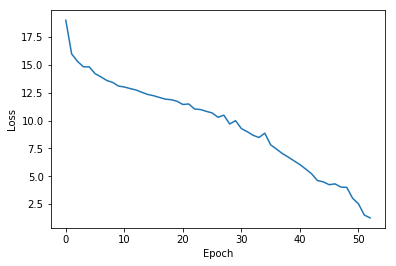

In [424]:
plt.plot([i for i in range(len(losses))], losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

The accuracy for the model was chatotic and uninformative, actually showing a downward pattern over time. The decoding is probably twisted somehow, but there was no time to figure out a better aproach.

In [0]:
leng,ap, pa, w =  map(list, zip(*history))

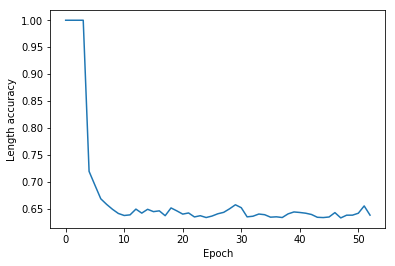

In [426]:
plt.plot([i for i in range(len(leng))], leng)
plt.ylabel('Length accuracy')
plt.xlabel('Epoch')
plt.show()

Text(0.5, 0, 'Epoch')

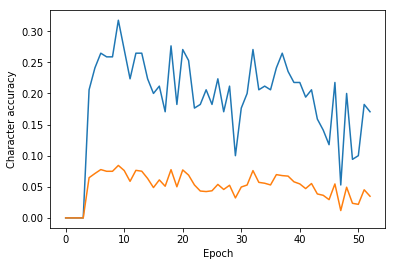

In [428]:
plt.plot( range(len(ap)),ap, label='Actual - predicted')
plt.plot( range(len(ap)),pa, label='Predicted - actual')
plt.ylabel('Character accuracy')
plt.xlabel('Epoch')